**Importamos Librerias**

In [2]:
import pandas as pd                             #para tratar los datasets
from sqlite3 import connect                     #para ayudarnos con los datasets usando lenguaje sql
import seaborn as sns                           #graficos
import matplotlib.pyplot as plt                 #graficos
import datetime as dt                           #para el tratamiento de datasets que contengan fechas de diferentes formatos
from wordcloud import WordCloud                 #para el uso de la herramienta wordcloud
from wordcloud import ImageColorGenerator
from wordcloud import STOPWORDS

**Importamos CSV**

In [3]:
coursera_cursos=pd.read_csv(r'Moocs\Coursera_courses.csv')
edx_cursos=pd.read_csv(r'Moocs\edx_courses.csv')
udemy_cursos=pd.read_csv(r'Moocs\udemy_courses.csv')
coursera_reviews=pd.read_csv(r'Moocs\Coursera_reviews.csv')

**Datos Coursera**

In [4]:
coursera_cursos.head(3)     #visualizamos ambas datasets que perteneces a la primera plataforma(coursera)

,name,institution,course_url,course_id
0,Machine Learning,Stanford University,https://www.coursera.org/learn/machine-learning,machine-learning
1,Indigenous Canada,University of Alberta,https://www.coursera.org/learn/indigenous-canada,indigenous-canada
2,The Science of Well-Being,Yale University,https://www.coursera.org/learn/the-science-of-...,the-science-of-well-being


In [5]:
coursera_reviews.head(3)

,reviews,reviewers,date_reviews,rating,course_id
0,"Pretty dry, but I was able to pass with just t...",By Robert S,"Feb 12, 2020",4,google-cbrs-cpi-training
1,would be a better experience if the video and ...,By Gabriel E R,"Sep 28, 2020",4,google-cbrs-cpi-training
2,Information was perfect! The program itself wa...,By Jacob D,"Apr 08, 2020",4,google-cbrs-cpi-training


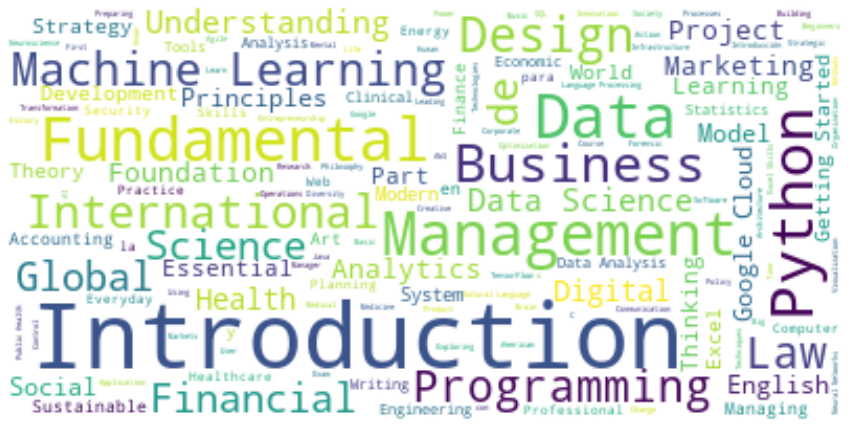

In [6]:
text = " ".join(i for i in coursera_cursos.name)        #ejecutamos el primer wordcloud para nuestro datasets en la columna de titulos
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [7]:
coursera_cursos['name'].duplicated().sum() #empezamos con la limpieza

1

In [8]:
coursera_cursos.loc[coursera_cursos['name'].duplicated(keep=False),'name'] #buscamos duplicados

6     Introduction to Psychology
54    Introduction to Psychology
Name: name, dtype: object

In [9]:
coursera_cursos.loc[[6,54]] #confirmamos duplicados

,name,institution,course_url,course_id
6,Introduction to Psychology,Yale University,https://www.coursera.org/learn/introduction-ps...,introduction-psychology
54,Introduction to Psychology,University of Toronto,https://www.coursera.org/learn/introduction-psych,introduction-psych


In [10]:
coursera_cursos.isna().sum() #buscamos nulos en el primer dataset

name           0
institution    0
course_url     0
course_id      0
dtype: int64

In [11]:
coursera_reviews.isna().sum()   #buscamos nulos en el segundo dataset

reviews         140
reviewers         0
date_reviews      0
rating            0
course_id         0
dtype: int64

In [12]:
conn = connect(':memory:')  # usamos el metodo connect para usar querys tipo SQL

In [13]:
coursera_cursos.to_sql('cc',conn,index=False)   #creamos tablas a partir de los datasets
coursera_reviews.to_sql('cr',conn,index=False)

1454711

In [107]:
ratio_negativo_cursera=pd.read_sql('SELECT reviews, rating as ratio FROM cr WHERE rating<=1 GROUP BY reviews',conn) #hacemos nuestra primera
                                                                                                                    #consulta, para crear un
                                                                                                                    #dataset que contenga solo
                                                                                                                    #reviews de bajo ratio   

In [108]:
ratio_negativo_cursera=ratio_negativo_cursera.dropna() #eliminamos nulos de nuestro resultado

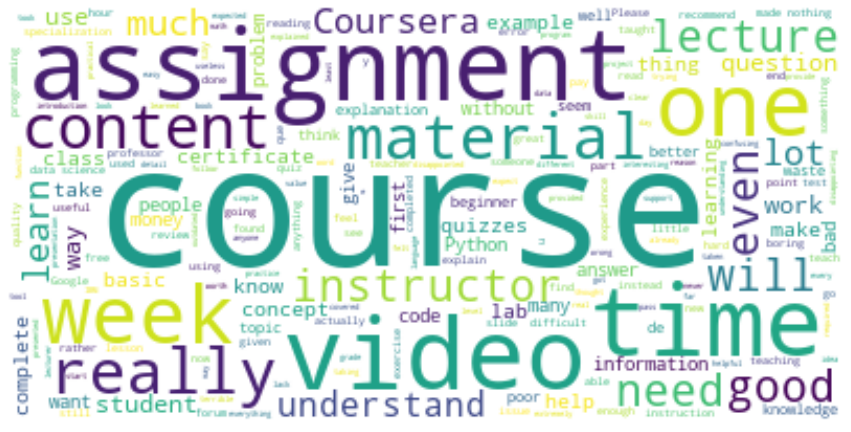

In [109]:
text = " ".join(i for i in ratio_negativo_cursera.reviews)          #y obtenemos nuestro wordcloud para ser analizado
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [86]:
ratio_cursera=pd.read_sql('SELECT cc.name, AVG(cr.rating) as ratio FROM cc cc JOIN cr cr ON(cc.course_id=cr.course_id) GROUP BY cc.name',conn)
#creamos una tabla que contenga el promedio de puntaje de cada curso

In [15]:
ratio_cursera.head(3) #resultado de la query anterior

,name,ratio
0,A Crash Course in Causality: Inferring Causal...,4.655556
1,A Law Student's Toolkit,4.697318
2,AI For Everyone,4.843551


In [16]:
ratio_cursera['satisfaccion']='' #creamos una columna que contendra un indicador a partir del rating de cada curso

In [17]:
for i in range(len(ratio_cursera)):                         #llenamos la columna
    a=ratio_cursera['ratio'][i]
    if a>=4.5:  
        ratio_cursera.at[i,'satisfaccion']='muy satisfecho'
    elif (4<=a and a<4.5):
        ratio_cursera.at[i,'satisfaccion']='satifecho'
    elif (3<=a and a<4):
        ratio_cursera.at[i,'satisfaccion']='neutro'
    elif a<3:
        ratio_cursera.at[i,'satisfaccion']='insatisfecho'
    

<AxesSubplot:xlabel='satisfaccion', ylabel='count'>

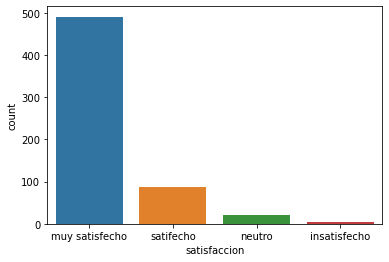

In [18]:
sns.countplot(x=ratio_cursera['satisfaccion'])  #y observamos el resultado

In [19]:
cursos_universidades=pd.read_sql('SELECT cc.institution, COUNT(cc.institution) as count_cursos, AVG(cr.rating) as ratio FROM cc cc JOIN cr cr ON(cc.course_id=cr.course_id) GROUP BY cc.institution',conn)
#creamos otro dataframe que contenga la cantidad de cursos que contenga cada institucion ademas del rating promedio de cada institucion

In [20]:
df_count_5=cursos_universidades.iloc[:,0:2].sort_values('count_cursos',ascending=False).head(10)
#como son varias insituciones en la plataforma vamos a solo visualizar a las 10 primeras con mas cursos 

In [21]:
df_count_others=pd.DataFrame(data = {               #y las demas instuciones sumaremos todos sus cursos y las dejaremos como "otras"
    'institution' : ['others'],
    'count_cursos' : [cursos_universidades.iloc[:,0:2]['count_cursos'][10:].sum()]
})

In [22]:
df_count_5=pd.concat([df_count_5,df_count_others])  #nuestro resultado
df_count_5

,institution,count_cursos
113,University of Michigan,167069
16,DeepLearning.AI,117029
28,Google,78613
34,IBM,70769
116,University of Pennsylvania,70531
67,Stanford University,63504
97,University of California San Diego,59589
41,Johns Hopkins University,57149
127,Yale University,51850
30,Google Cloud,49285


In [23]:
"""plt.pie(df_count_5['count_cursos'],labels=df_count_5['institution'],shadow=True,radius=3)
plt.show()"""

"plt.pie(df_count_5['count_cursos'],labels=df_count_5['institution'],shadow=True,radius=3)\nplt.show()"

In [24]:
cursos_universidades.loc[:,['institution','ratio']].sort_values('ratio',ascending=False).head(5)
#tambien revisamos los institutos con mejor ratio promedio

,institution,ratio
27,GitLab,5.000000
80,UCL School of Management,4.948276
29,Google - Spectrum Sharing,4.931034
32,Hebrew University of Jerusalem,4.928451
75,The University of Chicago,4.921771


In [25]:
fechas_coursera=coursera_reviews.loc[:,['date_reviews']]#obtenemos un dataset de las fechas para que sean tratadas
fechas_coursera

,date_reviews
0,"Feb 12, 2020"
1,"Sep 28, 2020"
2,"Apr 08, 2020"
3,"Feb 24, 2020"
4,"Jun 18, 2020"
...,...
1454706,"Aug 25, 2020"
1454707,"Jul 02, 2020"
1454708,"Jun 20, 2020"
1454709,"Jun 07, 2020"


In [26]:
for i in range(0,len(fechas_coursera)):#cambiamos el formato de fechas 
        x=dt.datetime.strptime(fechas_coursera['date_reviews'][i].strip(),'%b %d, %Y')
        fechas_coursera['date_reviews'][i]=x.strftime('%Y-%m-%d')

In [27]:
fechas_coursera['date_reviews']=pd.to_datetime(fechas_coursera['date_reviews'], format='%Y-%m-%d')#convertimos el tipo de variable

In [28]:
fechas_coursera['year']=fechas_coursera['date_reviews'].dt.strftime('%Y')#obtenemos la variable año de las fechas

<AxesSubplot:xlabel='year', ylabel='Count'>

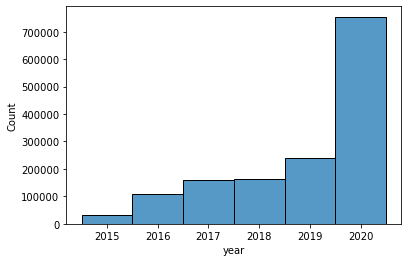

In [29]:
sns.histplot(data=fechas_coursera.sort_values('year'), x='year')#y ploteamos la cantidad de cursos que hay por año

<AxesSubplot:xlabel='date_reviews', ylabel='Count'>

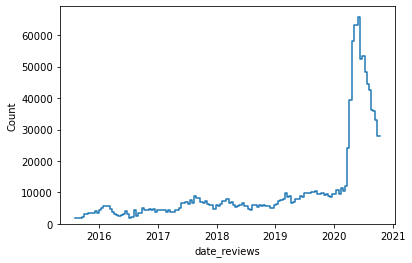

In [30]:
sns.histplot(data=fechas_coursera, x='date_reviews',element="step",fill=False)#un grafico mas preciso que muestra una caida en el ultimo año

**Cursos EDX**

In [110]:
edx_cursos.iloc[:,0:10].head(3) #observamos el dataset de nuestra segunda plataforma

,title,summary,n_enrolled,course_type,institution,instructors,Level,subject,language,subtitles
0,How to Learn Online,Learn essential strategies for successful onli...,124980,Self-paced on your time,edX,Nina Huntemann-Robyn Belair-Ben Piscopo,Introductory,Education & Teacher Training,English,English
1,Programming for Everybody (Getting Started wit...,"This course is a ""no prerequisite"" introductio...",293864,Self-paced on your time,The University of Michigan,Charles Severance,Introductory,Computer Science,English,English
2,CS50's Introduction to Computer Science,An introduction to the intellectual enterprise...,2442271,Self-paced on your time,Harvard University,David J. Malan-Doug Lloyd-Brian Yu,Introductory,Computer Science,English,English


In [111]:
edx_cursos.iloc[:,10:].head(3)

,course_effort,course_length,price,course_description,course_syllabus,course_url,precio_numero
0,2–3 hours per week,2 Weeks,FREE-Add a Verified Certificate for $49 USD,"Designed for those who are new to elearning, t...",Welcome - We start with opportunities to meet ...,https://www.edx.org/course/how-to-learn-online,49
1,2–4 hours per week,7 Weeks,FREE-Add a Verified Certificate for $49 USD,This course aims to teach everyone the basics ...,NaN,https://www.edx.org/course/programming-for-eve...,49
2,6–18 hours per week,12 Weeks,FREE-Add a Verified Certificate for $90 USD,"This is CS50x , Harvard University's introduct...",NaN,https://www.edx.org/course/cs50s-introduction-...,90


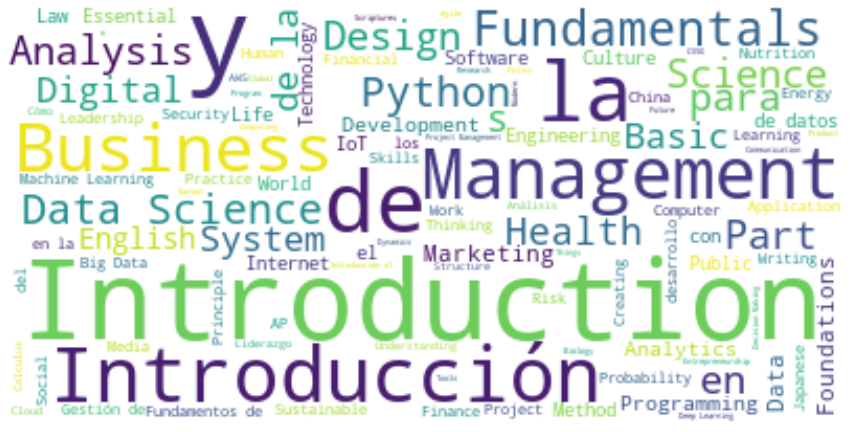

In [33]:
text = " ".join(i for i in edx_cursos.title)#creamos el segundo worcloud de los titulos de la segunda plataforma
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [34]:
edx_cursos['n_enrolled'] = edx_cursos['n_enrolled'].replace({',':''}, regex=True)#tranformamos la columna de cantidad de alumnos para que se 
                                                                                 #pueda tratar mejor

In [35]:
edx_cursos.shape

(975, 16)

In [36]:
edx_cursos.duplicated().sum()#buscamos duplicados

1

In [37]:
edx_cursos.drop_duplicates(inplace=True,ignore_index=True)#eliminamos duplicados

In [38]:
edx_cursos.shape

(974, 16)

In [39]:
edx_cursos.isna().sum()#buscamos nulos

title                   0
summary                53
n_enrolled            120
course_type             0
institution             0
instructors             3
Level                   0
subject                 0
language                0
subtitles               3
course_effort           0
course_length           0
price                   0
course_description     40
course_syllabus       557
course_url              0
dtype: int64

In [40]:
edx_cursos.to_sql('edx',conn,index=False) #creamos una tabla a partir del dataset

974

In [41]:
edx_conteo_inst=pd.read_sql('SELECT institution, COUNT(institution) as Nro_de_cursos, SUM(n_enrolled) as Nro_de_alumnos FROM edx GROUP BY institution',conn)
#creamos un dataset que haga un conteo de alumnos y cursos por institucion 

In [42]:
edx_conteo_inst.loc[:,['institution','Nro_de_cursos']].sort_values('Nro_de_cursos',ascending=False).head(10) #observamos los resultados

,institution,Nro_de_cursos
25,Harvard University,103
85,Universitat Politècnica de Valencia,47
39,Massachusetts Institute of Technology,41
17,Delft University of Technology,30
26,IBM,30
32,Inter-American Development Bank,29
70,The University of Queensland,26
68,The University of Michigan,22
55,Tecnológico de Monterrey,21
10,Columbia University,20


In [43]:
edx_conteo_inst.loc[:,['institution','Nro_de_alumnos']].sort_values('Nro_de_alumnos',ascending=False).head(10)

,institution,Nro_de_alumnos
25,Harvard University,13362623.0
70,The University of Queensland,2301994.0
85,Universitat Politècnica de Valencia,2117083.0
91,"University of California, Berkeley",1840798.0
39,Massachusetts Institute of Technology,1547111.0
10,Columbia University,1341270.0
32,Inter-American Development Bank,1115101.0
17,Delft University of Technology,1073553.0
22,Educational Testing Service,1022489.0
61,The Linux Foundation,1001977.0


In [44]:
edx_idioma=pd.read_sql('SELECT language, COUNT(language) as Nro FROM edx GROUP BY language',conn)
#creamos otro dataset para ver los ídiomas mas usados

In [45]:
edx_idioma.sort_values('Nro',ascending=False)#observamos los resultados

,language,Nro
1,English,776
2,Español,176
3,Français,7
4,Italiano,4
5,Português,4
7,中文,4
0,Deutsch,1
6,اللغة العربية,1
8,日本語,1


In [46]:
count_idioma=edx_idioma.iloc[:,0:2].sort_values('Nro',ascending=False).head(2)#visualizaremos solo los idiomas mas usados

In [47]:
count_idioma_others=pd.DataFrame(data = {               #y los demas idiomas los determinamos como "otros"
    'language' : ['otros'],
    'Nro' : [edx_idioma.iloc[:,0:2]['Nro'][2:].sum()]
})

In [48]:
idioma_edx=pd.concat([count_idioma,count_idioma_others]) #nuestro resultado
idioma_edx

,language,Nro
1,English,776
2,Español,176
0,otros,197


<AxesSubplot:xlabel='Nro', ylabel='language'>

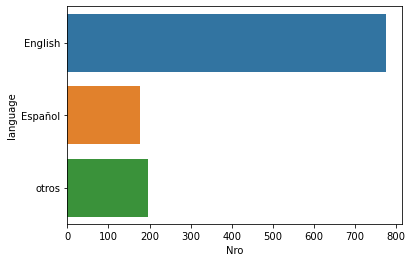

In [49]:
sns.barplot(data=idioma_edx, x='Nro',y='language') #graficamos el uso de idiomas

In [50]:
edx_subject=pd.read_sql('SELECT subject, COUNT(subject) as Nro FROM edx GROUP BY subject ORDER BY Nro DESC',conn)
#hacemos un dataset de la cantidad de cada materia  

In [51]:
edx_subject.head(10)

,subject,Nro
0,Computer Science,166
1,Business & Management,164
2,Data Analysis & Statistics,71
3,Humanities,64
4,Engineering,58
5,Social Sciences,51
6,Economics & Finance,46
7,Communication,39
8,Biology & Life Sciences,35
9,Language,34


In [52]:
nivel_curso_edx=pd.read_sql('SELECT Level, COUNT(Level) as Nro FROM edx GROUP BY Level ORDER BY Level DESC',conn)
#creamos otro dataset para obtener una proporcion de nivel de curso

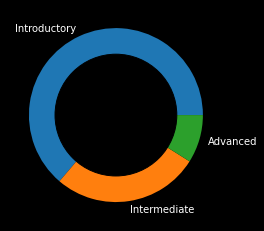

In [53]:
fig = plt.figure()                  #graficamos a partir del dataset anterior
fig.patch.set_facecolor('black')
plt.rcParams['text.color'] = 'white'
my_circle = plt.Circle( (0,0), 0.7, color='black')
plt.pie(nivel_curso_edx['Nro'], labels = nivel_curso_edx['Level'], wedgeprops = { 'linewidth' : 7})
p = plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

In [54]:
edx_precio=pd.read_sql('SELECT price as precio_numero, COUNT(price) as Nro FROM edx GROUP BY price ORDER BY Nro DESC',conn)
#hacemos otro dataframe para identificar la cantidad de precios que son mas recurrentes

In [55]:
edx_precio['precio_numero']=edx_precio['precio_numero'].str.extract('([0-9]+)')
#extraemos los numeros de la columna de precios

In [56]:
edx_precio.head(10)#observamos el resultado

,precio_numero,Nro
0,49,270
1,99,136
2,50,96
3,199,85
4,149,78
5,25,49
6,139,33
7,150,30
8,249,26
9,79,21


In [57]:
edx_cursos = pd.concat([edx_cursos,edx_precio['precio_numero']], axis=1)#agregamos al dataset original los precios en solo numeros

<AxesSubplot:xlabel='Nro', ylabel='precio_numero'>

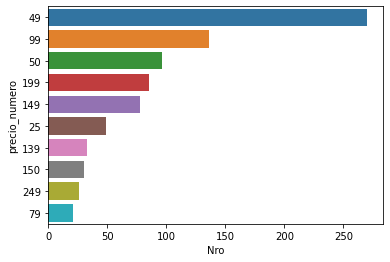

In [58]:
sns.barplot(data=edx_precio.head(10), x='Nro',y='precio_numero')#graficamos la tendencia de precios

In [59]:
edx_cursos['precio_numero']=edx_cursos['price'].str.extract('([0-9]+)')

In [60]:
duracion_curso_edx=pd.read_sql('SELECT course_length, course_effort, COUNT(course_length) as Nro FROM edx GROUP BY course_length, course_effort ORDER BY course_length',conn)
#creamos otro dataset buscando la cantidad de duracion de los diferentes cursos por semana y horas

In [61]:
semana_curso_edx=pd.read_sql('SELECT course_length, COUNT(course_length) as Nro FROM edx GROUP BY course_length ORDER BY Nro DESC',conn)
#creamos otro solo para la cantidad de duracion de un curso por semana

<AxesSubplot:xlabel='Nro', ylabel='course_length'>

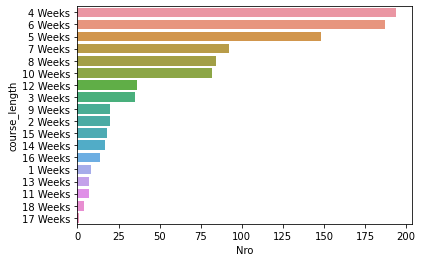

In [62]:
sns.barplot(data=semana_curso_edx, x='Nro',y='course_length')#graficamos el segundo resultado

In [63]:
"""duracion_pivote=duracion_curso_edx.pivot(index='course_length', columns='course_effort', values='Nro').fillna(0)"""

In [114]:
"""duracion_pivote.plot(kind='bar', stacked=True,figsize=(40,20))"""

"duracion_pivote.plot(kind='bar', stacked=True,figsize=(40,20))"

**Curso Udemy**

In [65]:
udemy_cursos.iloc[:,0:6].head(3)#observamos el tercer y ultimo dataset

,course_id,course_title,url,is_paid,price,num_subscribers
0,1070968,Ultimate Investment Banking Course,https://www.udemy.com/ultimate-investment-bank...,True,200,2147
1,1113822,Complete GST Course & Certification - Grow You...,https://www.udemy.com/goods-and-services-tax/,True,75,2792
2,1006314,Financial Modeling for Business Analysts and C...,https://www.udemy.com/financial-modeling-for-b...,True,45,2174


In [66]:
udemy_cursos.iloc[:,6:].head(3)

,num_reviews,num_lectures,level,content_duration,published_timestamp,subject
0,23,51,All Levels,1.5,2017-01-18T20:58:58Z,Business Finance
1,923,274,All Levels,39.0,2017-03-09T16:34:20Z,Business Finance
2,74,51,Intermediate Level,2.5,2016-12-19T19:26:30Z,Business Finance


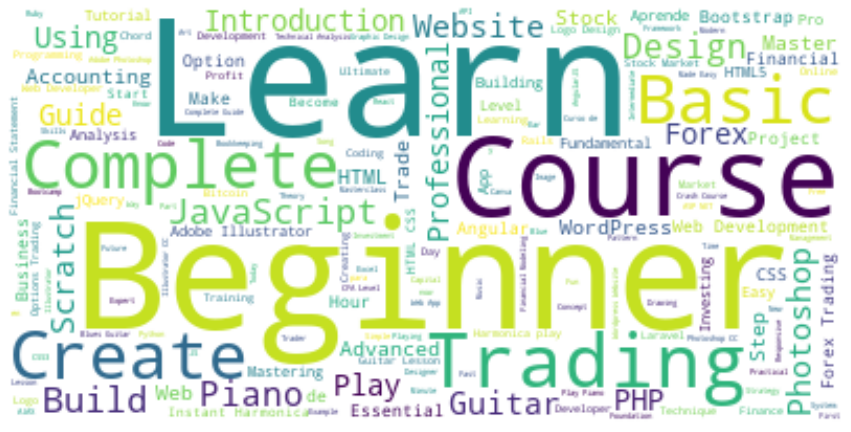

In [67]:
text = " ".join(i for i in udemy_cursos.course_title)#obtenemos el wordcloud de lso titulos de esta plataforma
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [68]:
udemy_cursos.duplicated().sum()#buscamos duplicados

6

In [69]:
udemy_cursos.drop_duplicates(inplace=True,ignore_index=True)#eliminamos duplicados

In [70]:
tiempo=udemy_cursos['published_timestamp'].str.split('T', expand=True)#separamos la fecha del tiempo en la columna de timestamp

In [71]:
tiempo.columns = ['fecha', 'tiempo']#nombramos las columnas del dataset nuevo 

In [72]:
udemy_cursos = pd.concat([udemy_cursos, tiempo], axis=1)#y unimos el dataset creado con el original

In [73]:
udemy_cursos.isnull().sum()#buscamos nulos

course_id              0
course_title           0
url                    0
is_paid                0
price                  0
num_subscribers        0
num_reviews            0
num_lectures           0
level                  0
content_duration       0
published_timestamp    0
subject                0
fecha                  0
tiempo                 0
dtype: int64

In [74]:
udemy_cursos.to_sql('udc',conn,index=False)#convertimos el dataset en una tabla

3672

In [75]:
cursos_pagos_udemy=pd.read_sql('SELECT is_paid, COUNT(is_paid) as Nro FROM udc GROUP BY is_paid',conn)
#creamos un dataset buscando la proporcion de cursos pagos y gratis

In [76]:
cursos_pagos_udemy['is_paid'][0]='gratis'#cambiamos los valores booleanos por 'gratis' y 'pago'
cursos_pagos_udemy['is_paid'][1]='pago'
cursos_pagos_udemy

,is_paid,Nro
0,gratis,310
1,pago,3362


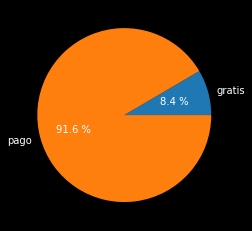

In [77]:
fig = plt.figure()#graficamos el resultado
fig.patch.set_facecolor('black')
plt.rcParams['text.color'] = 'white'
plt.pie(cursos_pagos_udemy['Nro'], labels = cursos_pagos_udemy['is_paid'], wedgeprops = { 'linewidth' : 7}, autopct="%0.1f %%")
p = plt.gcf()
plt.show()

In [78]:
ganancia_materia=pd.read_sql('SELECT subject, SUM(price*num_subscribers) as ganancia FROM udc GROUP BY subject',conn)
#creamos un dataset que haga un recuento de la ganancia por cada materia

<AxesSubplot:xlabel='ganancia', ylabel='subject'>

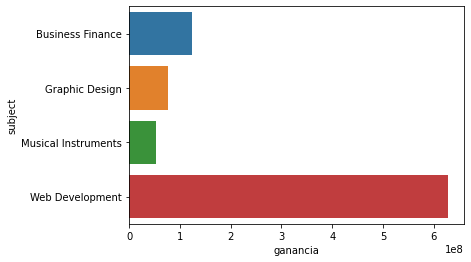

In [79]:
sns.barplot(data=ganancia_materia, x='ganancia',y='subject')#graficamos el resultado

In [80]:
nivel_curso_udc=pd.read_sql('SELECT level, COUNT(level) as Nro FROM udc GROUP BY level',conn)
#creamos un dataset buscando la proporcion de los niveles de curso

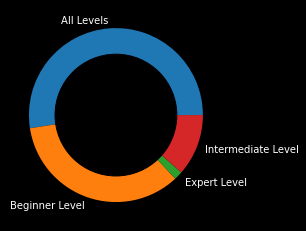

In [81]:
fig = plt.figure()#graficamos el resultado
fig.patch.set_facecolor('black')
plt.rcParams['text.color'] = 'white'
my_circle = plt.Circle( (0,0), 0.7, color='black')
plt.pie(nivel_curso_udc['Nro'], labels = nivel_curso_udc['level'], wedgeprops = { 'linewidth' : 7})
p = plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

In [82]:
udemy_cursos['fecha']=pd.to_datetime(udemy_cursos['fecha'], format='%Y-%m-%d')#cambiamos la variable de las fechas del dataset

<AxesSubplot:xlabel='fecha', ylabel='Count'>

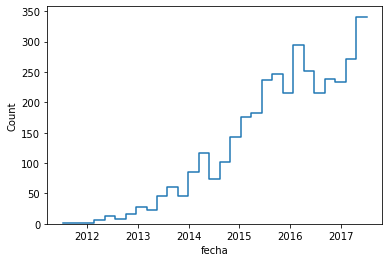

In [83]:
sns.histplot(data=udemy_cursos, x='fecha',element="step",fill=False)#Y graficamos el resultado

In [84]:
coursera_cursos.to_csv('Moocs_correjidos/coursera_cursos.csv', index=False)#finalmente llevamos los datasets ya limpios para ser usados en PowerBI
edx_cursos.to_csv('Moocs_correjidos/edx_cursos.csv', index=False)
udemy_cursos.to_csv('Moocs_correjidos/udemy_cursos.csv', index=False)
coursera_reviews.to_csv('Moocs_correjidos/coursera_reviews.csv', index=False)